## Big Picture
Using a 2009 dataset related to Portuguese "Vinho Verde" red wine, we want to predict the quality rating that a wine will be assigned. Note many people use this dataset to predict whether a wine will be good (receive a rating > 6.5) or bad (receiving a rating <=6.5). I will publish those results at the end, but my models goal is not classification.

We are only given eleven physio-chemical inputs and the label, a quality score between 0 and 10:
1. Fixed Acidity
2. Volatile Acidity
3. Citric Acidity
4. Residual Sugar
5. Chlorides
6. Free Sulfur Dioxide
7. Total Sulfur Dioxide
8. Density
9. pH
10. Sulphates
11. Alcohol Content
12. Quality (Label)

### Framing the Problem
Suppose we work for a winery which has decided to try an avant-garde approach to developing a wine. Rather than using traditional winemaking procedures, then tasting and rating the wine; the winery has another idea. They wants to create a theoretically high quality wine based on the above attributes, then create a wine with similair attribute values. The idea being that a theoretically good wine might make for a truly good wine.

To help in model developement, the winery has compiled a list of attributes that represent wines developed in the area and labeled these wines with a quality score given by a panel of experts. The first step in achieving their goal is developing a Machine Learning algorithm that closely predicts the rating given by these experts. Your job is to create that algorithm.

We have identified that our model is a supervised multivariate regression model. Supervised because we are given the labels and multivariate regression because we have many inputs and our prediction will be a real valued number.

### Select a Performance Measure
Now that we have framed our problem it is time to choose a performance measure. Given that we have decided we are facing a regression problem, and not classification, we should choose a measure thats compatable with regression models. A common choice is the Root Mean Squared Error (RMSE) defined by:
$$
RMSE(\vec{X}, h) = \sqrt{\frac{1}{m}\sum{(h(\vec{x^{(i)}}), y^{(i)}})^2}.
$$
But since our output values are relatively small, it may be more sensible to choose a measure with a stronger penalty for our estimation error. A good second option might be to use Mean Squared Error (MSE):
$$
MSE(\vec{X}, h) = \frac{1}{m}\sum{(h(\vec{x^{(i)}}), y^{(i)}})^2.
$$
However, because we are all familiar with the one through ten scale, an error of 16 for a quality prediction of nine, when the actual label was five would seem a bit confusing. For this reason we will stick with RMSE, so that our errors and quality measures fit the same scale.

### Check the Assumptions
Before continuing we should check our assumptions. It would be a shame to spend so much time working on a model that predicts as close to an expert as possible if the winery only wants to know if the wine would have a rating above some number (say 6.5). If that were the case we would actually be working on a classification problem, not regression! After double checking our assumptions with our boss, we are sure that we are on the right track.

## Preliminary Investigation of Data
Before investigating our data we first need to download it and place it in our working directory. It can often be useful to write code that downloads data automatically rather than doing it manually. This is particularly useful when new data is constently or periodically added to the repository. Having this function would allow us to automate the retrievel of new data rather than doing it ourself everytime.

In [1]:
import os
import pandas as pd

RED_WINE_URL = "https://raw.githubusercontent.com/aniruddhachoudhury/Red-Wine-Quality/master/winequality-red.csv"
CSV_NAME = "red_wine"

def save_csv_return_dataframe(url=RED_WINE_URL, name=CSV_NAME):
    os.makedirs("data", exist_ok=True)  # creates directory named {path}
    wine_data = pd.read_csv(url)  # retrieve data
    wine_data.to_csv("data/{}.csv".format(name))
    return wine_data

In [2]:
wine_raw = save_csv_return_dataframe()
wine_raw.head()  # show first five rows of pandas dataframe

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Each row represents a different wine. Each column is an attribute and the last column is our label, quality. We will need to remove this before training. Before that, lets get some more information on our data. Using the info() method we caan get the number of rows, attribute types, and the number of nonnull values.

In [3]:
wine_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


This new information shows us that we have 1,599 distinct wines in our dataset. We also notice that the nonnull count for each attribute is 1,599, meaning there are no missing values. All of our attributes are floating point numbers and the labels are integers. Our regression is going to output real numbers. We have to decide if this is okay or if we should switch to a classification model. After speaking with our supervisor we are told that it is important that our model be accurate, not that it produce integer values- *so we continue normally*. Lets continue investigating our data with the value_counts() method, now that we know the labels are integer numbers, we can infer that there are only 10 possible labels. This method will tell us how many wines, correspond to each label. Note this would be a bad idea if our labels were real valued numbers.

In [4]:
wine_raw["quality"].value_counts()

5    681
6    638
7    199
4     53
8     18
3     10
Name: quality, dtype: int64

We notice something concerning. We have no wines in our dataset that correspond to a rating of 1, 2, 9, or 10. We should disclose that this model will be most accurate for ratings of 5, 6, and 7. We should be skeptical of ratings of 4 and 8. Ratings of 1, 2, 9, and 10 should be dismissed because we have no data to represent wines of these calibers. It is important to keep track of the limitations of our model.

Before continuing let's take one more peak at our raw data. Using the describe() method we can get information about each attribute including: mean, standard deviation, max, min, and more. Let's check this out:

In [5]:
wine_raw.describe()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


Using the describe method, we have corroborated what we noticed above. The mean quality is 5.636 with a standard deviation of 0.8075. This implies a very small variance among the wines listed.

#### Authors Note
We will continue with regression, but perhaps this data is more suitable for classification. When starting this project I was interested in solving a regression problem, At this point I am relizing why this data is used for classification. I will reframe the problem below as a classification problem, but when I set out on this project I wanted to work with Support Vector Regressors, so I will make some sub-optimal decisions to ensure I get to use SVR's. I will in the future redo this project more correctly.

### Visualizing the Input Data
Sometimes it is convenient to visualize our input data. Visualization can give us a sense of "what our data looks like" or "what our data is doing". A common way to visualize data is with a histogram. A histogram will display how many instances have an attribute value that falls into some range. For particularly well behaved data these histograms might look like bell curves. We can build a histogram simply by calling hist(). 

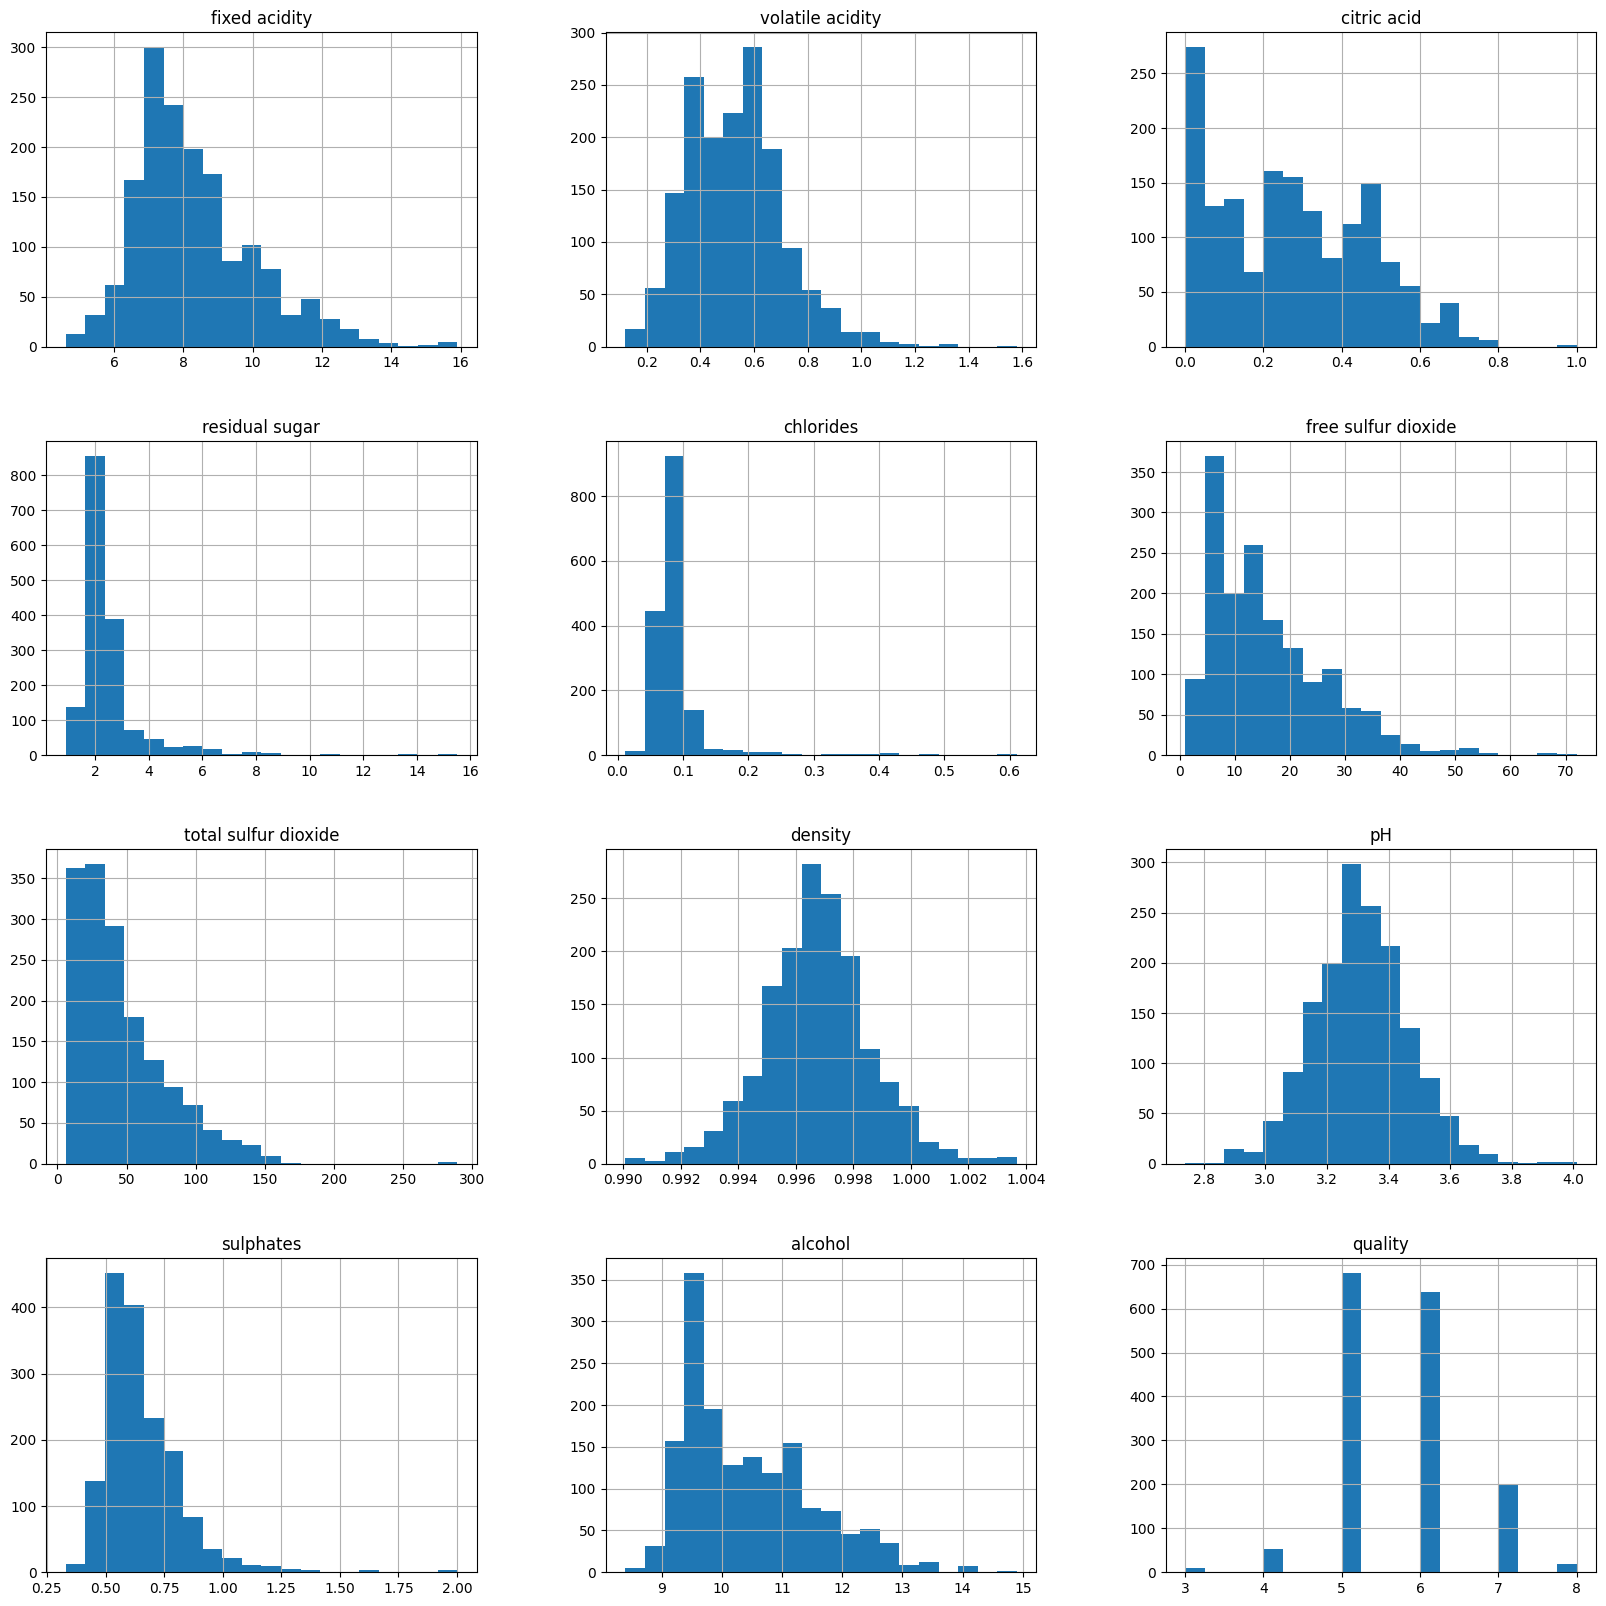

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt

wine_raw.hist(bins=20, figsize=(20,20))
plt.show()

#### What do we Learn?
1. We see that many of the histograms are tail heavy.
2. None of the attributes seem to have been capped.
3. Almost all the wines in our data were rated either 5 or 6.
4. Most of the data seems to fit some sort of bell curve.
5. The data falls on different scales.

At this point we are sure that our data is not adequate to solve the intended problem. We confer with our boss and are told to pivot our goal. Create a model that classifies a wine as either good (quality > 6.5) or bad (quality <= 6.5).

It is important to do this preliminary research before commiting to a goal. Imagine if we had set off to create a regression model right away. Our company might have found a combination of values that resulted in our model predicting that wine to have a quality score of a 9.8 with no bases for such claims. We have potentially saved our company a lot of money by doing this investigation.

### Reframing the Problem
Suppose we work for a winery which has decided to try an avant-garde approach to developing a wine. Rather than using traditional winemaking procedures, then tasting and rating the wine; the winery has another idea. They wants to create a theoretically good quality wine based on the data's attributes, then create a wine with similair attribute values. The idea being that a theoretically good wine might make for a truly good wine.

To help in model developement, the winery has compiled a list of attributes that represent wines developed in the area and labeled these wines with a quality score given by a panel of experts. The first step in achieving their goal is developing a Machine Learning algorithm that accurately predicts the quality of a wine. We are told that a good quality wine has a score greater than 6.5, otherwise it is bad quality. 

We have identified that our model is doing classification. We know our model will be a classification model because our output will be one of two possible, discrete, values- *good or bad*.

### Choosing an Evaluation Metric... Again
Now that we have framed our problem... again, it is time to choose a performance measure. Given that we have decided we are facing a classification problem, and not regression, we should choose a measure thats compatable with classification models. A common choice is accuracy defined by:
$$
Accuracy = \frac{Number  of  Correct  Predictions}{Total  Number  of  Wines}
$$

## Create a Test Set
Creating a test set is relatively straight forward. Randomize the data and then partition it into a training set and a testing set, where we save approximately twenty percent for testing.

Before we go off building a test set, we should stratify the data, so that we can get a sense of how many wines had a quality score greater than 6.5.

In [7]:
wine_raw["quality_cat"] = pd.cut(wine_raw["quality"],
                                bins=[0.0, 6.5, 11],
                                 labels = ["bad", "good"])
wine_raw["quality_cat"].value_counts() / len(wine_raw)

bad     0.86429
good    0.13571
Name: quality_cat, dtype: float64

Moving forward, we should drop the quality attribute in our data as this would be a dead give away for whether the wine is good or not. We won't do that until after we inspect our data a little bit further.

After we will build our train and test sets. We should check that the randomly compiled test set is representative of our data. We can do this by checking what percent of wines fall into each category.

In [8]:
from sklearn.model_selection import ShuffleSplit

split = ShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

for train_index, test_index in split.split(wine_raw, wine_raw["quality_cat"]):
    train_set_raw = wine_raw.loc[train_index]
    test_set_raw = wine_raw.loc[test_index]

test_set_raw["quality_cat"].value_counts() / len(test_set_raw)

bad     0.853125
good    0.146875
Name: quality_cat, dtype: float64

It appears that splitting our data randomly was sufficient enough to get a representative test and train set. We could not have done much better even if we stratified the data.

## Visualize the Data to Gain Insights
Though we have done some visualization already, we still have more to learn about our data. Up until now we only know the types of our attribuutes and have an idea on how each attribute is distributed. But we don't know much about how our data interacts with our target attribute.

### Looking for correlations
Because our data is relatively small, we can compute the correlations between every attribute and our "quality" attribute- *good thing we kept it*. 

In [9]:
corr_matrix = wine_raw.corr()
corr_matrix["quality"].sort_values(ascending=False)

/tmp/ipykernel_9167/743615314.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = wine_raw.corr()


quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
fixed acidity           0.124052
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

A correlation close to 1 indicates a strong positive correlation and -1 a strong negative correlation. Correlations close to 0 indicate that there is no clear correlation between an attribute and the target. Note also that these numbers only indicate linear correlations, there could be strong non-linear correlations in the data, so we should not be quick to remove attributes like "residual Sugar". Notice that alcohol seems to have the strongest linear correlation followed by volatile acidity.

Another way to visualize correlations between attributes is to use pandas scatter_matrix() function, which plots every attribute against every other attribute. Because we have 12 numerical attributes, we would get 144 scatter plots, this is too much so lets, only plot a few of the features.

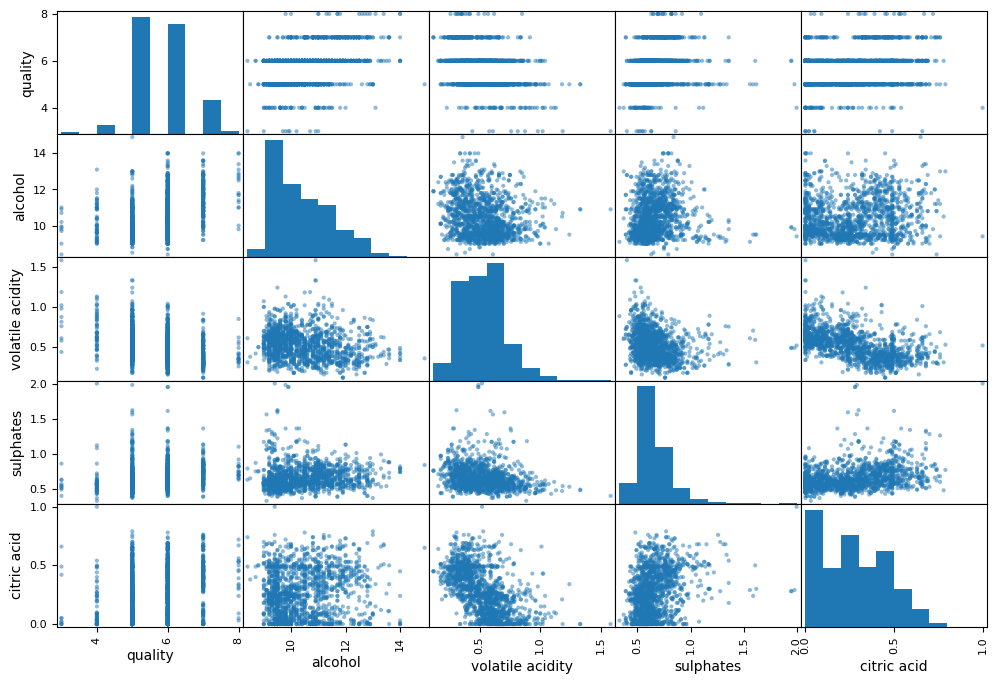

In [10]:
from pandas.plotting import scatter_matrix

attributes = ['quality', 'alcohol', 'volatile acidity', 'sulphates',
             'citric acid']
scatter_matrix(wine_raw[attributes], figsize=(12,8))
plt.show()

We immediately notice something funny. Because quality is an integer, our scatter plots show lines at each integer value. It is difficult to see whats going on here so maybe it would be best to exclude 'quality' from our plots.

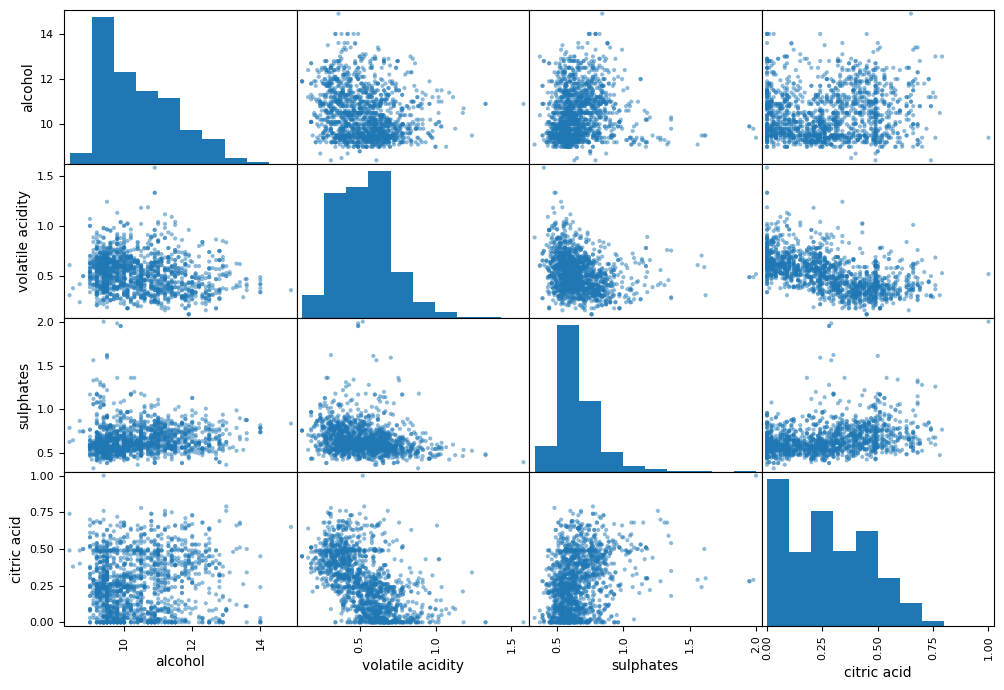

In [11]:
attributes = ['alcohol', 'volatile acidity', 'sulphates',
             'citric acid']
scatter_matrix(wine_raw[attributes], figsize=(12,8))
plt.show()

Visually, we dont notice much of a linear correlation among these attributes. Maybe 'volatile acidity' and 'citric acid' or 'alcohol' and 'sulphates' have a measurable relationship, but thats it.

### Experimenting with Attribute Combinations
Before continuing, we might want to try some attribute cobinations. Many attribute combinations don't really make sense: 'sulphates' per 'alcohol', but we may be able to come up with a few better combinations. 

When we measured the linear correlation among the attributes, I noticed a strong correlation among every acid feature. One interesting combination could be the sum of all these acid groups. Also, 'volatile acidity' was the only acid group with a negative correlation, so another interesting combination could be the sum of all other acid groups minus 'volatile acidity'. Or the sum of all acid groups except 'volatile acidity'. Let's try these:

In [12]:
wine_raw["acid sum"] = wine_raw["citric acid"] + wine_raw["fixed acidity"] + wine_raw["volatile acidity"]
wine_raw["absolute acid sum"] = wine_raw["citric acid"] + wine_raw["fixed acidity"] - wine_raw["volatile acidity"]
wine_raw["positive acid sum"] = wine_raw["citric acid"] + wine_raw["fixed acidity"]

corr_matrix = wine_raw.corr()
corr_matrix["quality"].sort_values(ascending=False)

/tmp/ipykernel_9167/3454768278.py:5: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = wine_raw.corr()


quality                 1.000000
alcohol                 0.476166
sulphates               0.251397
citric acid             0.226373
absolute acid sum       0.170299
positive acid sum       0.138527
fixed acidity           0.124052
acid sum                0.103754
residual sugar          0.013732
free sulfur dioxide    -0.050656
pH                     -0.057731
chlorides              -0.128907
density                -0.174919
total sulfur dioxide   -0.185100
volatile acidity       -0.390558
Name: quality, dtype: float64

All of the attribute combinations we tried have a correlation greater than .10 and the "absolute acid sum" combination had a correlation of 0.17, thats a pretty strong positive correlation.

## Preparing Data for Machine Learning Algorithms
Before we go any further, we should revert to an untouched dataset. Then, split the labels from the rest of the data and get rid of the quality attribute- *because thats a dead give away*:

In [13]:
wine_train = train_set_raw.drop(["quality", "quality_cat"], axis=1)
wine_train_labels = train_set_raw["quality"].copy()

wine_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol
493,8.7,0.690,0.31,3.0,0.086,23.0,81.0,1.00020,3.48,0.74,11.6
354,6.1,0.210,0.40,1.4,0.066,40.5,165.0,0.99120,3.25,0.59,11.9
342,10.9,0.390,0.47,1.8,0.118,6.0,14.0,0.99820,3.30,0.75,9.8
834,8.8,0.685,0.26,1.6,0.088,16.0,23.0,0.99694,3.32,0.47,9.4
705,8.4,1.035,0.15,6.0,0.073,11.0,54.0,0.99900,3.37,0.49,9.9


Notice that this does not include any of the attribute combinations that we created. If we want any of those, we should add them while we tranform our data in our data pipeline.

If our data included null values or categorical attriburtes, this would be the time to handle that, but since it doesn't we move on.

### Custom Transformers
We will have to create our own transformer if we want to combine some attributes. Moreover, our transformer should work seamlessly with Scikit-Learn functionalities (such as pipelines). This means we need three functions: fit(), transform(), and transform_fit(). The last one comes automatically when we add TransformerMixin as a base class. Here we don't have any functionality for the fit() function, but we should still add it.

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin
import numpy as np

fixed_ix, volatile_ix, citric_ix = "fixed acidity", "volatile acidity", "citric acid"

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, absolute_acid_sum = True):
        self.absolute_acid_sum = absolute_acid_sum
    def fit(self, X, y=None):
        return self  # nothing to see here
    def transform(self, X):
        if self.absolute_acid_sum:
            abs_acid_sum = X[fixed_ix] + X[volatile_ix] - X[citric_ix]
            return np.c_[X, abs_acid_sum]
        else:
            return self  # do nothing

### Feature Scaling
If we remember back to when we called the describe() method on our raw data, we saw that not all our data uses the same scale. In fact, sum attributes max out at 1 and others greater than 230. Generally, having data of varying scales is undesirable- *especially if the scales vary by orders of magnitude*. To fix this we will use SciKit- Learns StandardScaler for standardization. This maps our data into a new space where the mean for each attribute is zero with a unit variance.

### Transformation Pipeline
Now that we know how we want to transform our data, we are ready to build a transformation pipeline. This pipeline will be pretty short as we're only adding an attribute combination and then standardizing the input data.

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

full_pipeline = Pipeline([
    ('attribute_adder', CombinedAttributesAdder()),
    ('standard_scaler', StandardScaler())
])

wine_prepared = full_pipeline.fit_transform(wine_train)

## Select and Train a Model
So far we have framed the problem, retrieved the data, explored the data, sampled a testing and training set, and wrote a pipeline. Now we are finally ready to select and train a model.

The models we will train are: a Linear Regression, Random Forest Regressor, and a Support Vector Regressor.

#### Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

lin_reg = LinearRegression()
lin_reg.fit(wine_prepared, wine_train_labels)

wine_predictions = lin_reg.predict(wine_prepared)
lin_mse = mean_squared_error(wine_train_labels, wine_predictions)
lin_rmse = np.sqrt(lin_mse)
print(lin_mse)

0.4241911573139901


#### Random Forest Regressor

In [17]:
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor()
forest_reg.fit(wine_prepared, wine_train_labels)

wine_predictions = forest_reg.predict(wine_prepared)
forest_mse = mean_squared_error(wine_train_labels, wine_predictions)
forest_rmse = np.sqrt(forest_mse)
print(forest_mse)

0.04854136043784206


#### Support Vector Regressor
We will try two Support Vector Regressors, one with a linear kernel and the other with a Radial Basis Function (RBF) kernel.

In [18]:
from sklearn.svm import SVR

svr_lin_reg = SVR(kernel="linear")
svr_rbf_reg = SVR(kernel="rbf")

svr_lin_reg.fit(wine_prepared, wine_train_labels)
svr_rbf_reg.fit(wine_prepared, wine_train_labels)

wine_predictions_lin = svr_lin_reg.predict(wine_prepared)
wine_predictions_rbf = svr_rbf_reg.predict(wine_prepared)

svr_lin_mse = mean_squared_error(wine_train_labels, wine_predictions_lin)
svr_rbf_mse = mean_squared_error(wine_train_labels, wine_predictions_rbf)

svr_lin_rmse = np.sqrt(svr_lin_mse)
svr_rbf_rmse = np.sqrt(svr_rbf_mse)

print(svr_lin_mse)
print(svr_rbf_mse)

0.43126109380413297
0.30947632001411185


From these preliminary tests, we see that all of our models are showing a pretty low error. The best model thus far has been the Random Forest Regressor which produced an error less than 0.05, followed by the RBF Support Vector Regressor with an error of less than 0.31. Note these errors were calculated on the training set, meaning that all instances have already been seen by our model. It is highly likely that these errors will increase when we try to predict unseen instances. 

### Better Evaluation Using Cross-Validation
A good way to get a more accurate error for our model, is with cross-validation. We break our training set into x partitions and train the model on x-1 of the partitions, then evaluate it on the remaining partition. This gives us the advantage of seeing how our model performs on unseen data as well as gives us an idea of how "stable" the error is. We can get an idea of error stability because we train x models and calculate how similair their errors are. Let's do this for our two best models from above:

In [27]:
from sklearn.model_selection import cross_val_score

forest_scores = cross_val_score(forest_reg, wine_prepared, wine_train_labels,
                               scoring="neg_mean_squared_error", cv=10)
svr_rbf_scores = cross_val_score(svr_rbf_reg, wine_prepared, wine_train_labels,
                               scoring="neg_mean_squared_error", cv=10)

forest_rmse = np.sqrt(-forest_scores)
svr_rbf_rmse = np.sqrt(-svr_rbf_scores)

In [28]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard Deviation:", scores.std(),'\n')

print("DECISION TREE REGRESSOR")
display_scores(forest_rmse)

print("RBF SUPPORT VECTOR REGRESSOR")
display_scores(svr_rbf_rmse)

DECISION TREE REGRESSOR
Scores: [0.59735027 0.67149495 0.60714367 0.56018342 0.60431909 0.61974667
 0.55164527 0.68193715 0.46800274 0.57456317]
Mean: 0.5936386403118045
Standard Deviation: 0.058207426015234244 

RBF SUPPORT VECTOR REGRESSOR
Scores: [0.60968364 0.72270368 0.65696451 0.62193459 0.68397077 0.6046962
 0.63743584 0.69583624 0.49495053 0.58874751]
Mean: 0.6316923504283534
Standard Deviation: 0.06136218356099552 



Both of our models evaluated worse on unseen data- *as expected*. But they both managed to score fairly well. Looking at the scores, means, and standard deviations we notice that these two models scored extremely similairly. The Decision Tree Regressor barely scored better than the RBF Support Vector Machine. Despite this, I am going to continue only with the Support Vector Regressor. I believe with some hyperparameter tuning we can get some very good scores with this model.

## Fine-Tuning Our Model
We have narrowed our model search down to one, but very well could continue with both models from the last step. The model we will be concerning ourselves with is the Radial Basis Function Support Vector Regressor. SciKit-Learn offers two great methods for hyperparameter tuning, GridSearchCV and RandomizedSearchCV, and we will try both.

### Grid Search
Using Scikit-Learn's GridSearchCV, all we have to do is decide which hyperparameters we want to tune and what values we would like to try. From here, GridSearchCV will use cross-validation to try out all possible hyperparameter combinations and builds a report of their performance:

In [29]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    {'gamma': [0.001, 0.01, 0.1, 0.25, 0.5, 0.9], 'C':[0.25, 0.5, 1, 2, 5]},
]

svr_reg = SVR()
grid_search = GridSearchCV(svr_reg, param_grid, cv=5,
                          scoring='neg_mean_squared_error',
                          return_train_score=True)
grid_search.fit(wine_prepared, wine_train_labels)

GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.25, 0.5, 1, 2, 5],
                          'gamma': [0.001, 0.01, 0.1, 0.25, 0.5, 0.9]}],
             return_train_score=True, scoring='neg_mean_squared_error')

We can find the best hyperparameter combinations as follows:

In [30]:
grid_search.best_params_

{'C': 1, 'gamma': 0.1}

We can also get a list of all the scores:

In [31]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.6910222137716158 {'C': 0.25, 'gamma': 0.001}
0.6554267732936231 {'C': 0.25, 'gamma': 0.01}
0.6501237739624309 {'C': 0.25, 'gamma': 0.1}
0.6607521955873504 {'C': 0.25, 'gamma': 0.25}
0.6768908571999722 {'C': 0.25, 'gamma': 0.5}
0.7043159665293257 {'C': 0.25, 'gamma': 0.9}
0.6709736902562161 {'C': 0.5, 'gamma': 0.001}
0.653389326282956 {'C': 0.5, 'gamma': 0.01}
0.64332471785467 {'C': 0.5, 'gamma': 0.1}
0.6528065280930979 {'C': 0.5, 'gamma': 0.25}
0.6632306596272041 {'C': 0.5, 'gamma': 0.5}
0.6818447475829227 {'C': 0.5, 'gamma': 0.9}
0.6642177925214867 {'C': 1, 'gamma': 0.001}
0.6539387655286637 {'C': 1, 'gamma': 0.01}
0.6399856720411189 {'C': 1, 'gamma': 0.1}
0.649866019679313 {'C': 1, 'gamma': 0.25}
0.6574387239989087 {'C': 1, 'gamma': 0.5}
0.6696583970983295 {'C': 1, 'gamma': 0.9}
0.6613659023784327 {'C': 2, 'gamma': 0.001}
0.655665065840085 {'C': 2, 'gamma': 0.01}
0.6463536454669202 {'C': 2, 'gamma': 0.1}
0.6565932818611252 {'C': 2, 'gamma': 0.25}
0.6638084641981713 {'C': 2, 'gamma'

We see that our best score was only barely better than the cross-validation score from the previous section. Nontheless this is an improvement on our model.

### Randomized Search
The grid search approach is fine when we are exploring relativelyt few combinations, but what if we want to try a lot of combinations. Choosing 1,000 different valuse for each hyperparameter would be very, very tedious. This is where RandomizedSearchCV can help. Lets let it run for a bunch of iterations and see if it can find a better hyperparameter pair.

In [32]:
from sklearn.model_selection import RandomizedSearchCV

params = [
    {'kernel':['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma':['scale', 'auto'], 'C': [0.001, 0.025, 0.04, 0.5, 0.6, 0.75, 0.9, 1]}
]

svr_reg = SVR()
random_search = RandomizedSearchCV(svr_reg, params)
random_search.fit(wine_prepared, wine_train_labels)

RandomizedSearchCV(estimator=SVR(),
                   param_distributions=[{'C': [0.001, 0.025, 0.04, 0.5, 0.6,
                                               0.75, 0.9, 1],
                                         'gamma': ['scale', 'auto'],
                                         'kernel': ['linear', 'poly', 'rbf',
                                                    'sigmoid']}])

In [33]:
print("Best Params:", random_search.best_params_)
print("Score:", random_search.best_score_)

Best Params: {'kernel': 'linear', 'gamma': 'scale', 'C': 0.04}
Score: 0.3187319113783123


We have now obtained our best score yet! Let's evaluate our model on the test set.

## Evaluate Model on the Test Set
We have done a lot of work leading up to this point and our model is performing pretty well on the validation set. Let's keep in mind those parameters that we just found with our RandomizedSearchCV and build our final model.

In [36]:
final_model = random_search.best_estimator_

X_test = train_set_raw.drop(["quality", "quality_cat"], axis=1)
y_test = train_set_raw["quality"].copy()

X_test_prepared = full_pipeline.transform(X_test)

final_predictions = final_model.predict(X_test_prepared)

final_mse = mean_squared_error(y_test, final_predictions)
final_rmse = np.sqrt(final_mse)

print(final_rmse)

0.6568408852367258


### Authors Final Notes
This model could be easily improved in two ways. Approach the problem as a classification problem and not regression, or choose the Random Forest Regressor. The reason I did not opt to go with either of these options was purely for learning purposes. When approaching this problem I wanted experience with Support Vector Regressors. Soon I will publish a new model on the same data, but this time approaching the problem from the classification stand point.